# Model Training: Addestramento e Valutazione dei Modelli

In questo notebook ci occupiamo della fase di **Modeling** e **Evaluation**.

L'obiettivo è addestrare diversi algoritmi di Machine Learning per risolvere un problema di
**classificazione binaria**: prevedere se un film avrà successo (`1`) o sarà un flop (`0`)
basandosi sulle sue caratteristiche *a priori* (budget, genere, regista, stagione di uscita, ecc.).

Confronteremo le prestazioni dei modelli attraverso metriche robuste e analizzeremo quali feature
risultano più predittive.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)

sns.set_theme(style='whitegrid', palette='Blues_r')

## 1. Caricamento Dati e Split Stratificato

Carichiamo `dataset_features.csv` prodotto dal FeatureEngineering e rieseguiamo lo split
con lo stesso `random_state=42` per garantire la **riproducibilità** dei risultati.

Utilizziamo uno **split stratificato** (`stratify=y`) per mantenere le proporzioni delle classi
in entrambi i set dato il leggero sbilanciamento del dataset.

Applichiamo lo `StandardScaler` sulle feature numeriche continue per i modelli sensibili alla scala
(Logistic Regression, SVM): variabili con range molto diversi (budget in milioni vs runtime in minuti)
possono distorcere l'apprendimento.

In [3]:
df = pd.read_csv('../data/processed/dataset_features.csv')

X = df.drop(columns=['success'])
y = df['success']

#split stratificato 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#scaling delle feature numeriche continue
colonne_da_scalare = [
    'budget', 'popularity', 'runtime',
    'release_year', 'release_month',
    'n_genres', 'n_keywords', 'cast_size'
]
colonne_da_scalare = [c for c in colonne_da_scalare if c in X_train.columns]

scaler = StandardScaler()
X_train = X_train.copy()
X_test  = X_test.copy()
X_train[colonne_da_scalare] = scaler.fit_transform(X_train[colonne_da_scalare])
X_test[colonne_da_scalare]  = scaler.transform(X_test[colonne_da_scalare])

print(f"Training set : {X_train.shape[0]} film, {X_train.shape[1]} feature")
print(f"Test set     : {X_test.shape[0]} film")
print(f"Tasso successo train: {y_train.mean()*100:.1f}% | test: {y_test.mean()*100:.1f}%")
print("\nDati pronti per l'addestramento.")

Training set : 2583 film, 36 feature
Test set     : 646 film
Tasso successo train: 42.6% | test: 42.6%

Dati pronti per l'addestramento.


## 2. Selezione degli Algoritmi

Testiamo cinque algoritmi diversi per capire quale riesce a prevedere meglio il successo di un film:

1. **Logistic Regression**: Il modello più semplice e lineare, che usiamo come punto di partenza (*baseline*).
2. **Decision Tree (Albero Decisionale)**: Crea una serie di domande a cascata (es. "Il budget è > 50M?"). Presenta un elevato rischio di imparare i dati "a memoria" (overfitting).
3. **Random Forest**: Unisce le forze di decine di alberi decisionali, risultando molto più stabile e preciso.
4. **SVM (Support Vector Machine)**: Traccia un confine matematico netto per separare i Flop dai Successi.
5. **XGBoost**: L'algoritmo più avanzato della lista, infatti impara progressivamente dai propri errori.

Per compensare il leggero sbilanciamento delle classi, usiamo `class_weight='balanced'`
dove disponibile.

In [4]:
modelli = {
    'Logistic Regression': LogisticRegression(
        max_iter=10000, class_weight='balanced', random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        class_weight='balanced', random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, class_weight='balanced', random_state=42
    ),
    'SVM': SVC(
        kernel='rbf', class_weight='balanced', probability=True, random_state=42
    ),
    'XGBoost': XGBClassifier(
        random_state=42, eval_metric='logloss', verbosity=0
    )
}

print(f"Modelli da testare: {list(modelli.keys())}")

Modelli da testare: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'XGBoost']


## 3. Addestramento e Valutazione

Per ogni modello calcoliamo:
- **Accuracy**: percentuale di previsioni corrette
- **Precision**: dei film previsti come successo, quanti lo sono davvero
- **Recall**: dei film veramente di successo, quanti riusciamo a identificare
- **F1-Score**: media armonica di precision e recall, utile con classi sbilanciate
- **ROC-AUC**: area sotto la curva ROC, misura la capacità discriminativa del modello
- **CV F1 (5-fold)**: F1 media su 5 fold di cross-validation, più robusta del semplice test set

In [5]:
risultati = []

for nome, modello in modelli.items():
    #addestramento
    modello.fit(X_train, y_train)
    y_pred = modello.predict(X_test)

    # Probabilità per ROC-AUC
    if hasattr(modello, 'predict_proba'):
        y_prob = modello.predict_proba(X_test)[:, 1]
    else:
        y_prob = modello.decision_function(X_test)

    # Cross-validation F1
    cv_f1 = cross_val_score(modello, X_train, y_train, cv=5, scoring='f1').mean()

    risultati.append({
        'Modello'  : nome,
        'Accuracy' : accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall'   : recall_score(y_test, y_pred, zero_division=0),
        'F1-Score' : f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC'  : roc_auc_score(y_test, y_prob),
        'CV F1 (5-fold)': cv_f1
    })
    print(f"✓ {nome} completato")

df_risultati = pd.DataFrame(risultati).set_index('Modello').round(4)
print("\n=== Riepilogo Metriche ===")
display(df_risultati.sort_values('F1-Score', ascending=False))

✓ Logistic Regression completato
✓ Decision Tree completato
✓ Random Forest completato
✓ SVM completato
✓ XGBoost completato

=== Riepilogo Metriche ===


,Accuracy,Precision,Recall,F1-Score,ROC-AUC,CV F1 (5-fold)
Modello,,,,,,
XGBoost,0.9241,0.8924,0.9345,0.9130,0.9791,0.9006
Random Forest,0.9195,0.8832,0.9345,0.9081,0.9725,0.9015
SVM,0.9149,0.8642,0.9491,0.9047,0.9715,0.8824
Logistic Regression,0.9118,0.8682,0.9345,0.9002,0.9730,0.8884
Decision Tree,0.8793,0.8456,0.8764,0.8607,0.8789,0.8472


## 4. Confronto Visivo delle Metriche

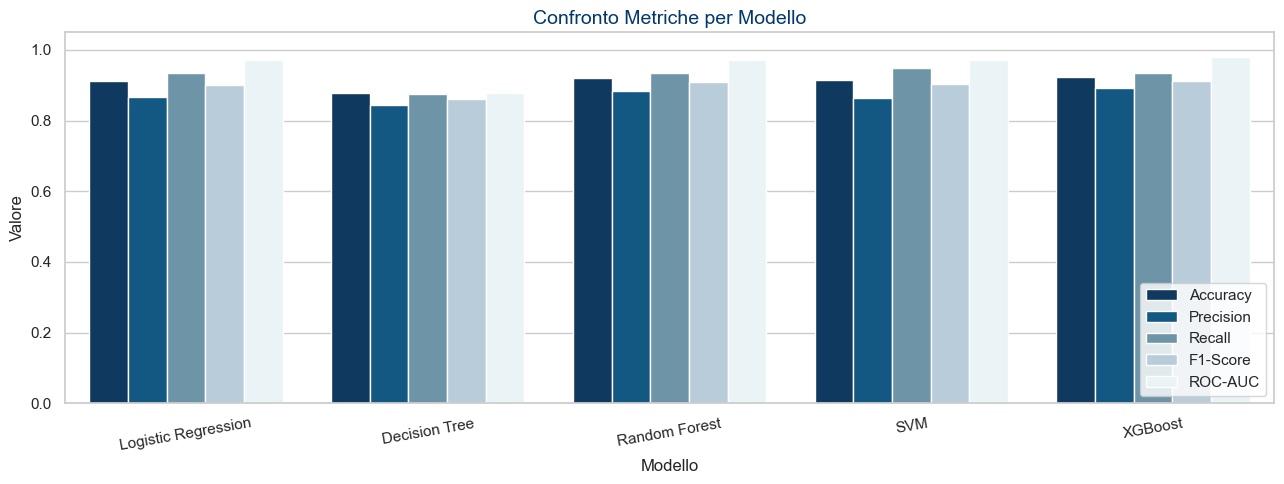

In [6]:
df_plot = df_risultati[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].reset_index()
df_melt = df_plot.melt(id_vars='Modello', var_name='Metrica', value_name='Valore')

plt.figure(figsize=(13, 5))
ax = sns.barplot(data=df_melt, x='Modello', y='Valore', hue='Metrica',
                 palette=['#03396c', '#005b96', '#6497b1', '#b3cde0', '#e8f4f8'])
plt.title('Confronto Metriche per Modello', fontsize=14, color='#03396c')
plt.ylabel('Valore')
plt.ylim(0, 1.05)
plt.xticks(rotation=10)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('../docs/model_comparison.png', bbox_inches='tight')
plt.show()

## 5. Confusion Matrix dei Modelli Migliori

La confusion matrix mostra nel dettaglio dove ogni modello sbaglia:
- **Falsi Negativi (FN)**: film di successo classificati come flop (perdiamo opportunità)
- **Falsi Positivi (FP)**: film flop classificati come successo (sovrastimiamo)

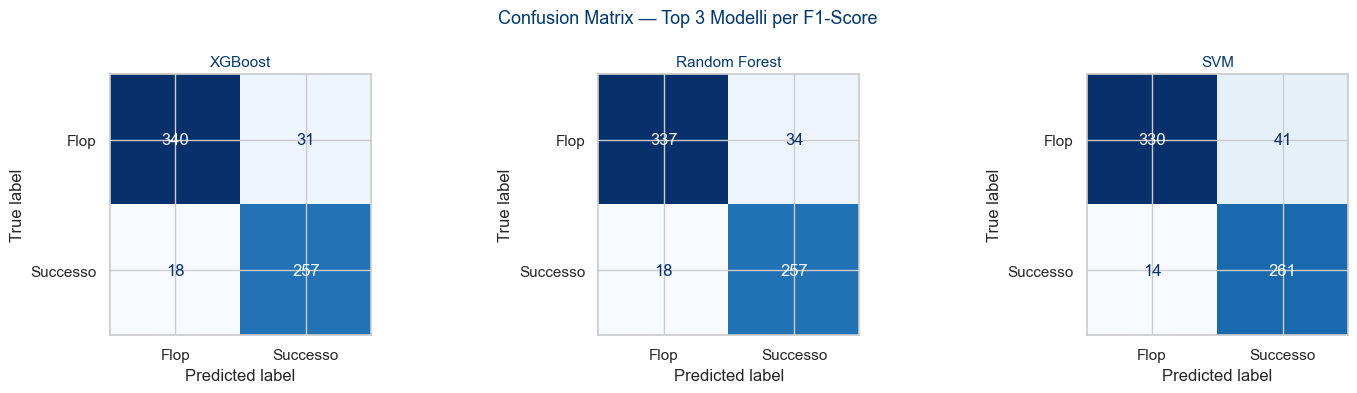

In [7]:
#mostriamo le confusion matrix dei top 3 modelli per F1-Score
top3 = df_risultati['F1-Score'].sort_values(ascending=False).head(3).index.tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, nome in zip(axes, top3):
    modello = modelli[nome]
    y_pred  = modello.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Flop', 'Successo'])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(nome, color='#03396c', fontsize=11)

plt.suptitle('Confusion Matrix — Top 3 Modelli per F1-Score', fontsize=13, color='#03396c')
plt.tight_layout()
plt.savefig('../docs/confusion_matrices.png', bbox_inches='tight')
plt.show()

## 6. Curva ROC

La curva ROC (Receiver Operating Characteristic) mostra il trade-off tra
**True Positive Rate** (recall) e **False Positive Rate** al variare della soglia di classificazione.
Un modello perfetto avrebbe AUC = 1.0; uno casuale avrebbe AUC = 0.5.

C:\Users\annac\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\utils\_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
C:\Users\annac\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\utils\_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
C:\Users\annac\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\utils\_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
C:\Users\annac\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\utils\_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curv

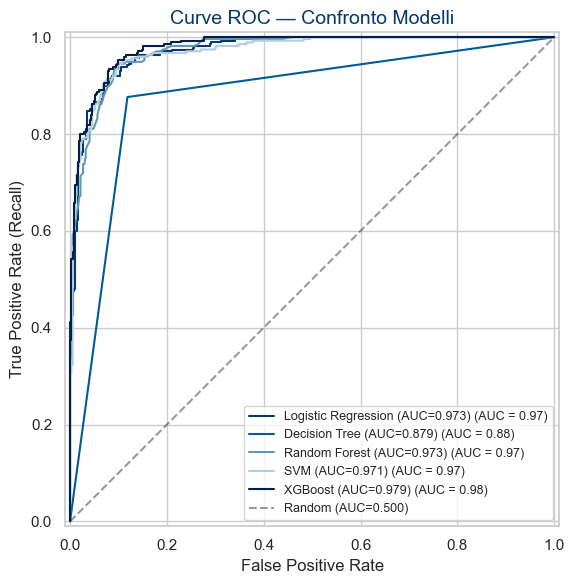

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
colori_roc = ['#03396c', '#005b96', '#6497b1', '#b3cde0', '#011f4b']

for (nome, modello), colore in zip(modelli.items(), colori_roc):
    if hasattr(modello, 'predict_proba'):
        y_prob = modello.predict_proba(X_test)[:, 1]
    else:
        y_prob = modello.decision_function(X_test)
    auc = roc_auc_score(y_test, y_prob)
    RocCurveDisplay.from_predictions(
        y_test, y_prob, name=f'{nome} (AUC={auc:.3f})',
        ax=ax, color=colore
    )

ax.plot([0, 1], [0, 1], 'k--', alpha=0.4, label='Random (AUC=0.500)')
ax.set_title('Curve ROC — Confronto Modelli', fontsize=14, color='#03396c')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate (Recall)')
ax.legend(loc='lower right', fontsize=9)
plt.tight_layout()
plt.savefig('../docs/roc_curves.png', bbox_inches='tight')
plt.show()

## 7. Ottimizzazione del Modello Migliore con Grid Search

Identifichiamo il modello con il miglior F1-Score e lo ottimizziamo tramite **Grid Search**
con **Cross-Validation a 5 fold** per trovare i migliori iperparametri.

La cross-validation divide il training set in 5 parti: addestra su 4 e valida sulla quinta,
ripetendo il processo 5 volte. Questo produce una stima più robusta rispetto al semplice test set.

In [9]:
nome_migliore = df_risultati['F1-Score'].idxmax()
print(f"Modello con miglior F1-Score: {nome_migliore}")
print(df_risultati.loc[nome_migliore])

Modello con miglior F1-Score: XGBoost
Accuracy          0.9241
Precision         0.8924
Recall            0.9345
F1-Score          0.9130
ROC-AUC           0.9791
CV F1 (5-fold)    0.9006
Name: XGBoost, dtype: float64


In [10]:
#griglie di iperparametri per i modelli più comuni
param_grids = {
    'Random Forest': {
        'n_estimators'     : [100, 200],
        'max_depth'        : [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf' : [1, 2]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth'   : [3, 5, 7],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample'   : [0.8, 1.0]
    },
    'Logistic Regression': {
        'C'      : [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver' : ['liblinear']
    },
    'Decision Tree': {
        'max_depth'        : [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf' : [1, 2, 4]
    },
    'SVM': {
        'C'    : [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    }
}

if nome_migliore in param_grids:
    print(f"Avvio Grid Search per: {nome_migliore}")
    print("(Potrebbe richiedere qualche minuto...)")

    grid_search = GridSearchCV(
        modelli[nome_migliore],
        param_grids[nome_migliore],
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    print(f"\nMigliori iperparametri: {grid_search.best_params_}")
    print(f"Miglior F1 (CV):        {grid_search.best_score_:.4f}")

    modello_ottimizzato = grid_search.best_estimator_
else:
    print(f"Griglia non definita per '{nome_migliore}', uso il modello già addestrato.")
    modello_ottimizzato = modelli[nome_migliore]

Avvio Grid Search per: XGBoost
(Potrebbe richiedere qualche minuto...)
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Migliori iperparametri: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Miglior F1 (CV):        0.9132


## 8. Valutazione Finale del Modello Ottimizzato sul Test Set

=== Risultati Finali: XGBoost (ottimizzato) ===
  Accuracy  : 0.9211  (92.1%)
  Precision : 0.8836
  Recall    : 0.9382
  F1-Score  : 0.9101
  ROC-AUC   : 0.9792


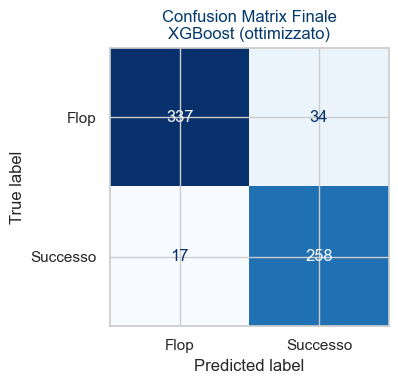

In [11]:
y_pred_final = modello_ottimizzato.predict(X_test)

acc   = accuracy_score(y_test, y_pred_final)
prec  = precision_score(y_test, y_pred_final, zero_division=0)
rec   = recall_score(y_test, y_pred_final, zero_division=0)
f1    = f1_score(y_test, y_pred_final, zero_division=0)

if hasattr(modello_ottimizzato, 'predict_proba'):
    y_prob_final = modello_ottimizzato.predict_proba(X_test)[:, 1]
else:
    y_prob_final = modello_ottimizzato.decision_function(X_test)
auc = roc_auc_score(y_test, y_prob_final)

print(f"=== Risultati Finali: {nome_migliore} (ottimizzato) ===")
print(f"  Accuracy  : {acc:.4f}  ({acc*100:.1f}%)")
print(f"  Precision : {prec:.4f}")
print(f"  Recall    : {rec:.4f}")
print(f"  F1-Score  : {f1:.4f}")
print(f"  ROC-AUC   : {auc:.4f}")

#confusion matrix finale
fig, ax = plt.subplots(figsize=(5, 4))
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Flop', 'Successo'])
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title(f'Confusion Matrix Finale\n{nome_migliore} (ottimizzato)', color='#03396c')
plt.tight_layout()
plt.savefig('../docs/confusion_matrix_final.png', bbox_inches='tight')
plt.show()

## 9. Feature Importance

Analizziamo quali feature hanno avuto il maggior peso nella decisione del modello.
Questo ci permette di capire quali caratteristiche di un film sono davvero predittive del suo successo.

Top 15 Feature più importanti (XGBoost):


,Feature,Importance
33,director_te,0.358563
34,lead_actor_te,0.184219
35,main_company_te,0.097436
1,popularity,0.083791
0,budget,0.054144
4,release_year,0.035199
3,cast_size,0.029508
6,n_genres,0.026443
7,n_keywords,0.026295
5,release_month,0.022966


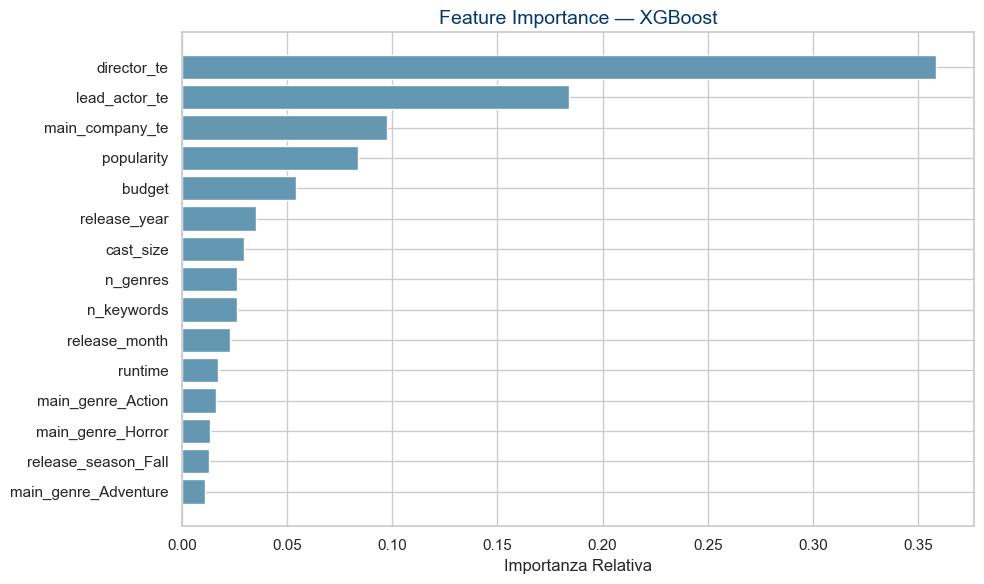

In [12]:
# Feature importance disponibile per alberi e XGBoost
if hasattr(modello_ottimizzato, 'feature_importances_'):
    importances = modello_ottimizzato.feature_importances_
    feat_imp = (
        pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
        .sort_values('Importance', ascending=False)
    )

    print(f"Top 15 Feature più importanti ({nome_migliore}):")
    display(feat_imp.head(15))

    plt.figure(figsize=(10, 6))
    top15 = feat_imp.head(15)
    plt.barh(top15['Feature'][::-1], top15['Importance'][::-1], color='#6497b1')
    plt.title(f'Feature Importance — {nome_migliore}', fontsize=14, color='#03396c')
    plt.xlabel('Importanza Relativa')
    plt.tight_layout()
    plt.savefig('../docs/feature_importance.png', bbox_inches='tight')
    plt.show()

elif hasattr(modello_ottimizzato, 'coef_'):
    # Logistic Regression: coefficienti come proxy dell'importanza
    coef = np.abs(modello_ottimizzato.coef_[0])
    feat_imp = (
        pd.DataFrame({'Feature': X_train.columns, 'Importance': coef})
        .sort_values('Importance', ascending=False)
    )

    print("Top 15 Feature per |coefficiente| (Logistic Regression):")
    display(feat_imp.head(15))

    plt.figure(figsize=(10, 6))
    top15 = feat_imp.head(15)
    plt.barh(top15['Feature'][::-1], top15['Importance'][::-1], color='#6497b1')
    plt.title('Feature Importance (|coeff.|) — Logistic Regression', fontsize=14, color='#03396c')
    plt.xlabel('|Coefficiente|')
    plt.tight_layout()
    plt.savefig('../docs/feature_importance.png', bbox_inches='tight')
    plt.show()
else:
    print(f"Feature importance non disponibile direttamente per {nome_migliore}.")

## 10. Conclusioni Finali

Il progetto ha testato la capacità predittiva del Machine Learning nel mercato cinematografico
usando esclusivamente caratteristiche *a priori* — informazioni disponibili prima che il film
venga rilasciato.

**Principali evidenze dall'analisi delle feature:**

- **Budget e Popularity** dominano la capacità predittiva: i film con maggiori investimenti
  e più hype pre-uscita tendono significativamente al successo.
- **Il Target Encoding di regista e attore protagonista** risulta informativo: la storia
  di successo di chi c'è dietro e davanti alla macchina da presa è predittiva.
- **Il genere ha un impatto limitato** rispetto alle variabili economiche: il successo
  trascende la categoria tematica del film.
- **La stagione di uscita** (estate e dicembre/inverno) mostra un lieve vantaggio,
  coerente con le strategie di uscita dei blockbuster.

**Limiti del modello:**
I fattori più predittivi del successo (qualità della sceneggiatura, marketing, word-of-mouth,
concorrenza al botteghino) sono difficilmente quantificabili e non presenti nel dataset.
Il modello cattura strutture statistiche aggregate, non la qualità intrinseca di un'opera.